# Preprocesado
Comenzamos cargando las librerías necesarias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import IPython
import IPython.display

Cargamos el dataset en memoria, se trata de un txt que utiliza ; como separador.

In [2]:
# Definimos una función para la conversión de tipos
def convert_dtype_to_float(x):
    if not x:
        return 0.0
    try:
        return float(x)
    except:
        return 0.0

In [3]:
# Definimos los tipos de cada atributo para evitar que pandas lance un warning indicando que ciertas columnas tiene un "mixed type"
converters = {'Global_active_power': convert_dtype_to_float, 'Global_reactive_power': convert_dtype_to_float,
       'Voltage': convert_dtype_to_float, 'Global_intensity': convert_dtype_to_float, 'Sub_metering_1': convert_dtype_to_float, 'Sub_metering_2': convert_dtype_to_float,
       'Sub_metering_3': convert_dtype_to_float}

In [4]:
# Finalmente, cargamos el dataset en memoria
df = pd.read_csv('dataset/household_power_consumption.txt', 
                 sep=';', 
                 converters=converters,
                 parse_dates={'data': ['Date', 'Time']},
                 infer_datetime_format=True,
                 index_col='data'
                )
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
data,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


Mostramos información básica sobre el dataset

In [5]:
df.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [6]:
df = df.drop(['Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'], axis=1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 1 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Global_active_power  float64
dtypes: float64(1)
memory usage: 31.7 MB


In [8]:
df.describe()

,Global_active_power
count,2.075259e+06
mean,1.077950e+00
std,1.057642e+00
min,0.000000e+00
25%,3.040000e-01
50%,5.780000e-01
75%,1.520000e+00
max,1.112200e+01


In [9]:
df.head()

,Global_active_power
data,
2006-12-16 17:24:00,4.216
2006-12-16 17:25:00,5.360
2006-12-16 17:26:00,5.374
2006-12-16 17:27:00,5.388
2006-12-16 17:28:00,3.666


In [10]:
len(df)

2075259

In [11]:
df = df.resample('h').sum()

In [12]:
len(df)

34589

In [13]:
df.head()

,Global_active_power
data,
2006-12-16 17:00:00,152.024
2006-12-16 18:00:00,217.932
2006-12-16 19:00:00,204.014
2006-12-16 20:00:00,196.114
2006-12-16 21:00:00,183.388


# División en training y test
70%, 20% ,10%

In [14]:
n = len(df)

train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]


In [15]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [16]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=['Global_active_power'])
print(w1)

w2 = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=['Global_active_power'])
print(w2)

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['Global_active_power']
Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Global_active_power']


Definimos el método split_window para partir una ventana en entrenamiento y pruebas

In [17]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [18]:
# example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
#                            np.array(train_df[100:100+w2.total_window_size]),
#                            np.array(train_df[200:200+w2.total_window_size])
#                           ])
example_window = tf.stack([np.array(test_df[:w2.total_window_size]),
                           np.array(test_df[100:100+w2.total_window_size]),
                           np.array(test_df[200:200+w2.total_window_size])
                          ])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 1)
Inputs shape: (3, 6, 1)
Labels shape: (3, 1, 1)


In [19]:
w2.example = example_inputs, example_labels

In [20]:
def plot(self, model=None, plot_col='Global_active_power', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

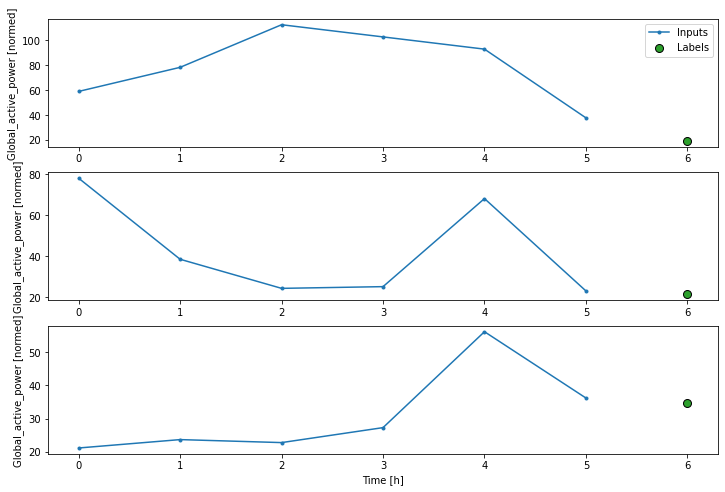

In [21]:
w2.plot()

# Creación de un dataset
Definimos el método make_dataset, que recibe como entrada un DataFrame de serie temporal y lo convierte en un tf.data.Dataset de (input_window, label_window) empleando para ello la función tf.keras.utils.timeseries_dataset_from_array:

In [22]:
# De momento, usaremos únicamente la target variable (Household dataset)
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32
    )
    
    ds = ds.map(self.split_window)
    
    return ds

WindowGenerator.make_dataset = make_dataset

In [23]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [24]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [25]:
# Iteramos sobre un conjunto de dataset para producir lotes concretos:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 1)
Labels shape (batch, time, features): (32, 1, 1)


# Modelos de un solo paso
Configuramos un objeto WindowGenerator para producir pares de un solo paso del tipo (input, label)

## Baseline
Copiar el valor anterior

In [26]:
single_step_window = WindowGenerator(
    input_width = 1, label_width=1,shift=1,
    label_columns = ['Global_active_power']
)

single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Global_active_power']

In [27]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 1)
Labels shape (batch, time, features): (32, 1, 1)


In [28]:
# Creamos un Baseline
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [29]:
column_indices = {name: i for i, name in enumerate(df.columns)}

In [30]:
baseline = Baseline(label_index=column_indices['Global_active_power'])

baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test,verbose=0)

217/217 [==============================] - 0s 976us/step - loss: 1591.3964 - mean_absolute_error: 26.4987


Creamos una ventana más amplia. 24 horas de entradas y etiquetas consecutivas a la vez.

In [31]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['Global_active_power'])


wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Global_active_power']

In [32]:
print("Input shape:", wide_window.example[0].shape)
print("Output shape:", baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 1)
Output shape: (32, 24, 1)


Imprimiendo el baseline (lo único que hace el baseline es copiar el anterior)

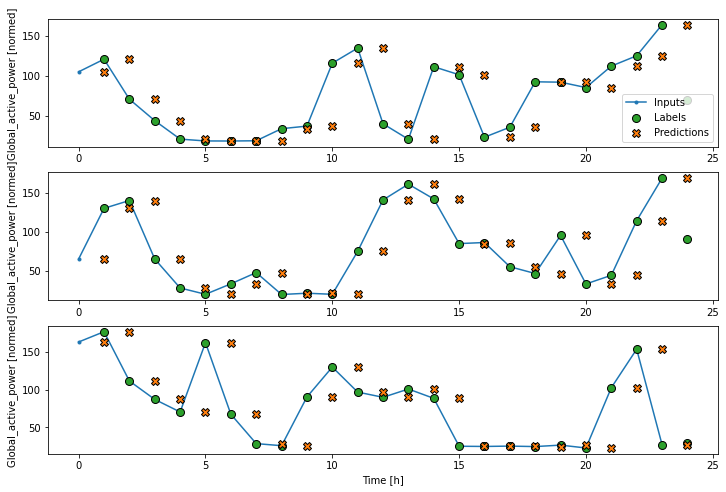

In [33]:
wide_window.plot(baseline)

## Modelo lineal
Aplicamos una transformación lineal entre el input y el output. En este caso el output en un momento del tiempo (un timestep) depende únicamente de dicho paso. Usamos una capa densa de tensorflow commo función de activación para crear un modelo lineal. Solo transforma el último eje de datos de (batch, time, inputs) a (batch, time, units).

In [34]:
linear_model = tf.keras.Sequential([tf.keras.layers.Dense(units=1)])

In [35]:
print('Input shape: ', single_step_window.example[0].shape)
print('Output shape: ', linear_model(single_step_window.example[0]).shape)

Input shape:  (32, 1, 1)
Output shape:  (32, 1, 1)


Entrenamos a la función

In [36]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    
    model.compile(loss=tf.losses.MeanSquaredError(),
                 optimizer=tf.optimizers.Adam(),
                 metrics=[tf.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train, epochs=MAX_EPOCHS, validation_data = window.val, callbacks=[early_stopping])
    
    return history

In [37]:
history = compile_and_fit(linear_model, single_step_window)

val_performance['Linear'] = linear_model.evaluate(single_step_window.val)

performance['Linear'] = linear_model.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
757/757 [==============================] - 2s 2ms/step - loss: 3964.0137 - mean_absolute_error: 42.2798 - val_loss: 2091.6167 - val_mean_absolute_error: 31.8855
Epoch 2/20
757/757 [==============================] - 1s 1ms/step - loss: 1829.3268 - mean_absolute_error: 27.6291 - val_loss: 1528.1807 - val_mean_absolute_error: 25.9755
Epoch 3/20
757/757 [==============================] - 1s 1ms/step - loss: 1640.0162 - mean_absolute_error: 26.0102 - val_loss: 1511.0581 - val_mean_absolute_error: 25.9462
Epoch 4/20
757/757 [==============================] - 1s 1ms/step - loss: 1629.4883 - mean_absolute_error: 25.9066 - val_loss: 1504.7480 - val_mean_absolute_error: 25.8555
Epoch 5/20
757/757 [==============================] - 1s 905us/step - loss: 1622.3411 - mean_absolute_error: 25.7923 - val_loss: 1497.4985 - val_mean_absolute_error: 25.7505
Epoch 6/20
757/757 [==============================] - 1s 949us/step - loss: 1615.1625 - mean_absolute_error: 25.6856 - val_loss: 1490.3075

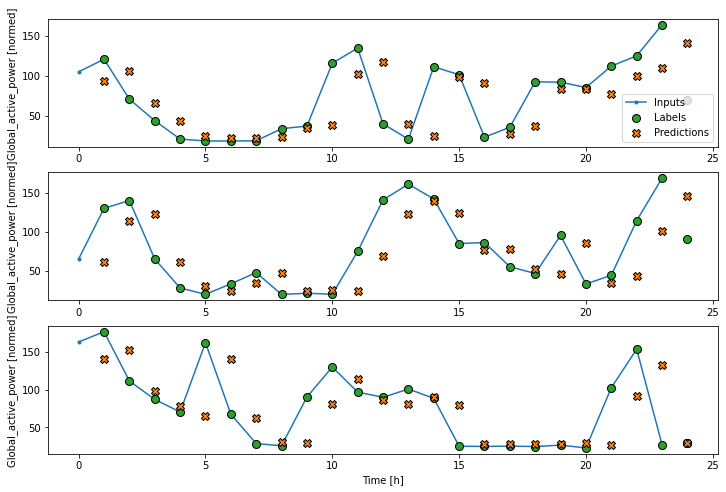

In [38]:
wide_window.plot(linear_model)

Podemos imprimir los pesos de las capas, lo que nos permite analizar los pesos asignados a cada input, esto tiene más sentido cuando estamos usando múltiples atributos como entrada.

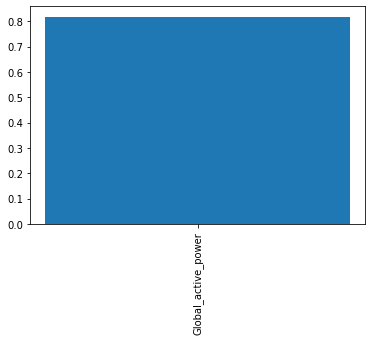

In [39]:
plt.bar(x=range(len(train_df.columns)),
       height=linear_model.layers[0].kernel[:,0].numpy())

axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

## Dense
Esta vez utilizaremos un modelo denso con funciones de activación

In [40]:
dense_model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='sigmoid'),
    tf.keras.layers.Dense(units=32, activation='sigmoid'),
    tf.keras.layers.Dense(units=1)  # No aplicamos función de activación en la última
])

history = compile_and_fit(dense_model, single_step_window)

val_performance['Dense'] = dense_model.evaluate(single_step_window.val)
performance['Dense'] = dense_model.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
757/757 [==============================] - 2s 2ms/step - loss: 6094.0347 - mean_absolute_error: 54.7848 - val_loss: 5309.1401 - val_mean_absolute_error: 52.6274
Epoch 2/20
757/757 [==============================] - 1s 2ms/step - loss: 4702.4775 - mean_absolute_error: 45.6784 - val_loss: 4103.6250 - val_mean_absolute_error: 45.8142
Epoch 3/20
757/757 [==============================] - 1s 2ms/step - loss: 3801.6191 - mean_absolute_error: 41.0335 - val_loss: 3246.1619 - val_mean_absolute_error: 40.1872
Epoch 4/20
757/757 [==============================] - 1s 2ms/step - loss: 3144.3545 - mean_absolute_error: 37.2944 - val_loss: 2637.0044 - val_mean_absolute_error: 36.1095
Epoch 5/20
757/757 [==============================] - 1s 2ms/step - loss: 2680.4060 - mean_absolute_error: 34.6071 - val_loss: 2211.0229 - val_mean_absolute_error: 33.6613
Epoch 6/20
757/757 [==============================] - 1s 2ms/step - loss: 2350.1162 - mean_absolute_error: 32.4209 - val_loss: 1943.8698 - v

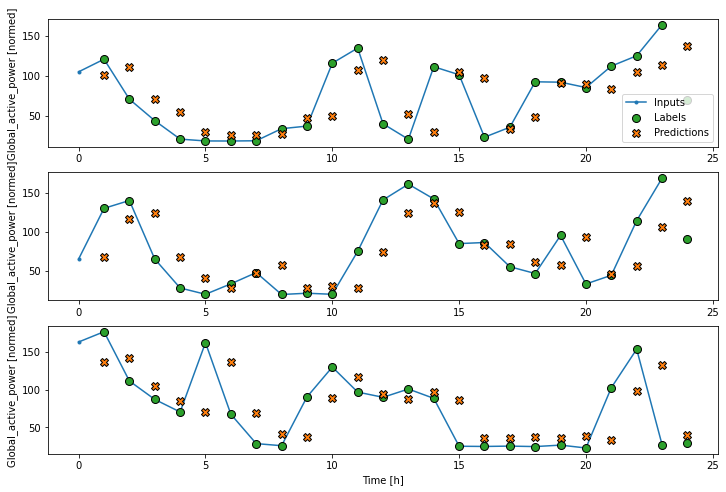

In [41]:
wide_window.plot(dense_model)

In [42]:
len(df)

34589

## Multi-step dense
Multi-step dense aprende de los n pasos anteriores. Un single-step model no tiene contexto sobre los valores actuales de sus inputs. Es incapaz de ver cómo las variables de input cambian con el tiempo. Para solucionar esto el modelo necesita acceso a múltiples pasos.

Los modelos anteriores trataban cada paso de manera independiente. En este caso, el modelo toma múltiples timesteps como entradas para el modelo, produciendo un único output.

In [43]:
# Creamos un WindowGenerator que producirá batches con inputs de tres horas y labels de una hora.
CONV_WIDTH = 3

conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Global_active_power'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['Global_active_power']

Text(0.5, 1.0, 'Dadas tres horas de input, predecimos una hora en el futuro')

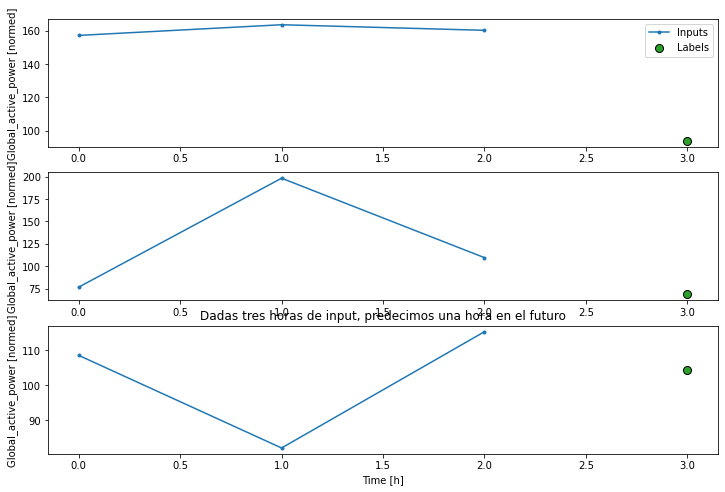

In [44]:
conv_window.plot()
plt.title("Dadas tres horas de input, predecimos una hora en el futuro")

Podemos crear un modelo denso con una ventana de entrada de múltiples pasos, usando tf.keras.layers.Flatten como primera capa del modelo. 

In [45]:
multi_step_dense = tf.keras.Sequential([
    # Forma: (tiempo, atributos) => (tiempo*atributos)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='sigmoid'),
    tf.keras.layers.Dense(units=32, activation='sigmoid'),
    tf.keras.layers.Dense(units=1),
    
    # Volver a añadir la dimensión del tiempo
    # Forma: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1,-1])
])

In [46]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 1)
Output shape: (32, 1, 1)


In [47]:
# 
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

217/217 [==============================] - 0s 1ms/step - loss: 1419.4661 - mean_absolute_error: 26.2048


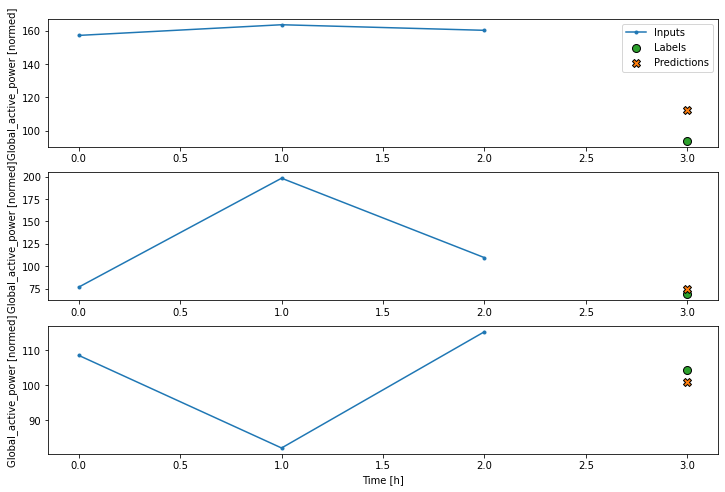

In [48]:
conv_window.plot(multi_step_dense)

El principal problema de este modelo es que el modelo resultante solo puede ser ejecutado con ventanas de entrada que tengan exactamente ese tamaño, algo que soluciona el modelo convolucional.

# Multi-step models
Al contrario que en single-step models, en multi-steps models aprendemos a predecir múltiples pasos en el futuro. Hay dos enfoques principales:
1. **Single shot predictions:** Se predice la serie completa de una vez. 
1. **Autoregressive predictions:** El modelo solo predice un paso y utiliza su salida como nueva entrada


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

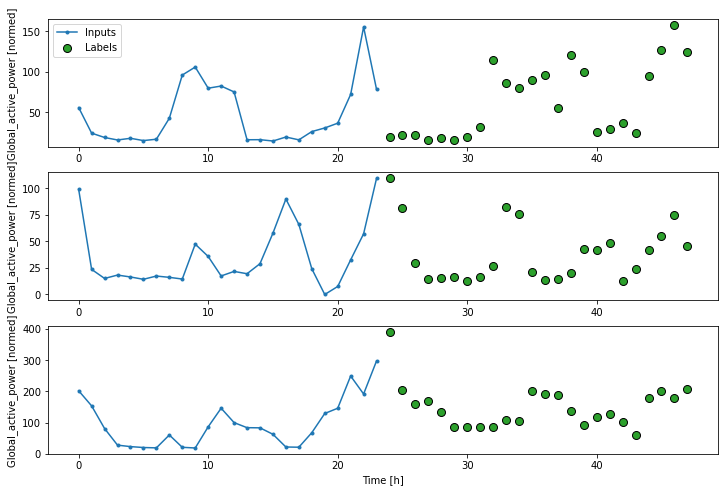

In [50]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS)

multi_window.plot()
multi_window

## Baselines
### Baseline 1: Repetir input anterior
Definimos un baseline que se limite a repetir el input anterior

215/215 [==============================] - 1s 1ms/step - loss: 4771.0396 - mean_absolute_error: 52.3133


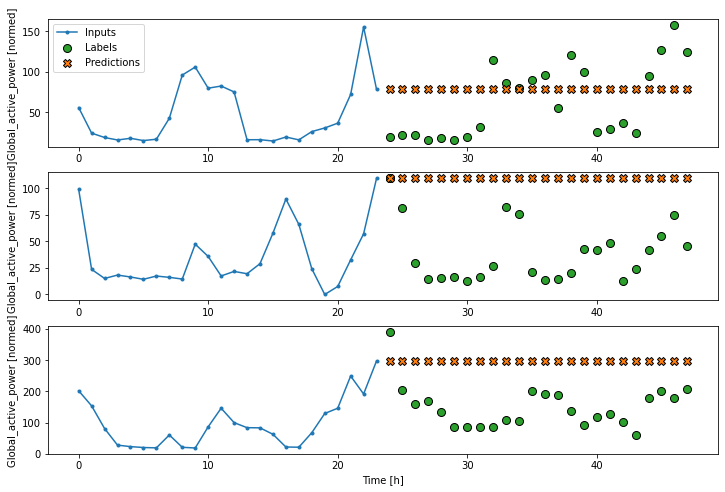

In [51]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

### Baseline 2: Repetir la ventana anterior
Repetimos el día anterior

215/215 [==============================] - 0s 877us/step - loss: 3074.4651 - mean_absolute_error: 38.5994


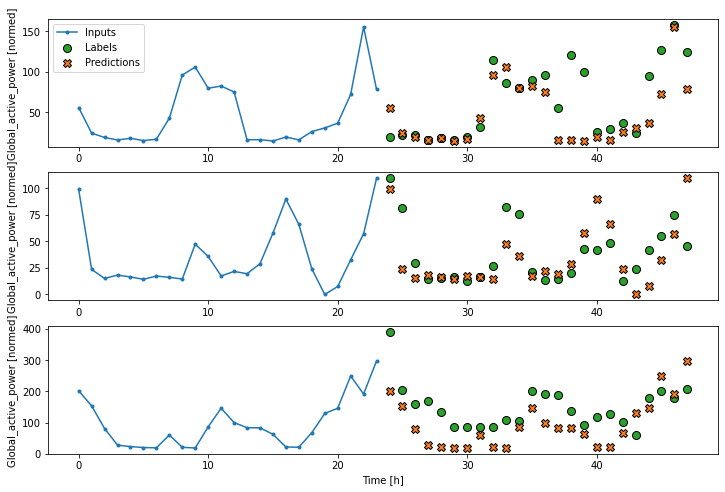

In [52]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

## Single-shot models
### Modelo lineal
Comenzamos usando una capa densa como entrada. El principal inconveniente de este approach reside en que solamente se puede realizar una predicción de baja dimensionalidad del comportamiento.

In [53]:
num_features=df.shape[1]

215/215 [==============================] - 0s 1ms/step - loss: 3473.7141 - mean_absolute_error: 43.8451


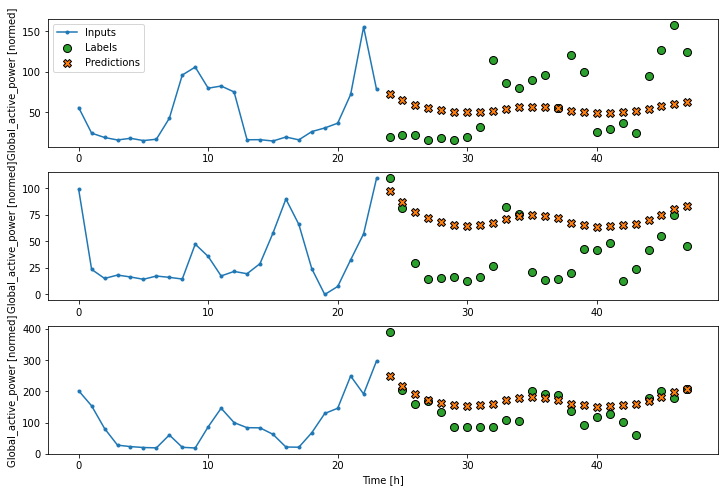

In [54]:
multi_linear_model = tf.keras.Sequential([
    # Seleccionar el último timestep
    # Forma: [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                         kernel_initializer=tf.initializers.zeros()),
    # Shape =>[batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

### CNN
Usamos un single-shot model con una red neuronal convolucional

215/215 [==============================] - 0s 1ms/step - loss: 2487.0432 - mean_absolute_error: 39.9352


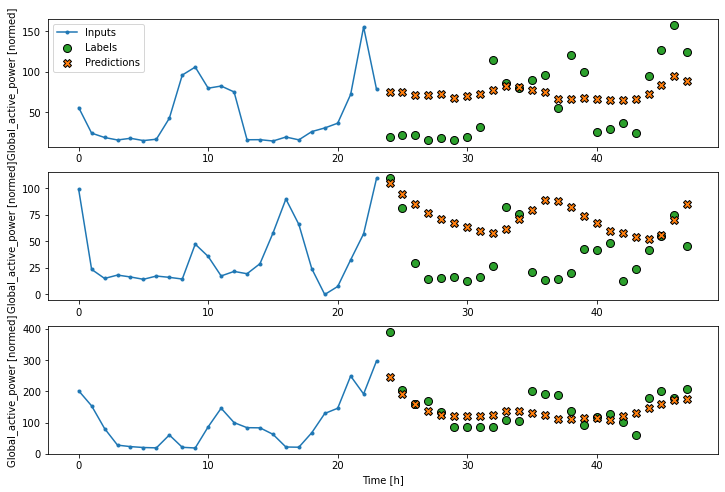

In [55]:
CONV_WIDTH = 3

multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

### RNN
Una red RNN puede aprender a usar un historial de inputs, si son relevantes para las predicciones que está realizando el modelo. En este caso, el modelo acumulará el estado interno durante 24 horas, antes de hacer una sola predicción para las próximas 24.

215/215 [==============================] - 1s 3ms/step - loss: 2385.7920 - mean_absolute_error: 39.3562


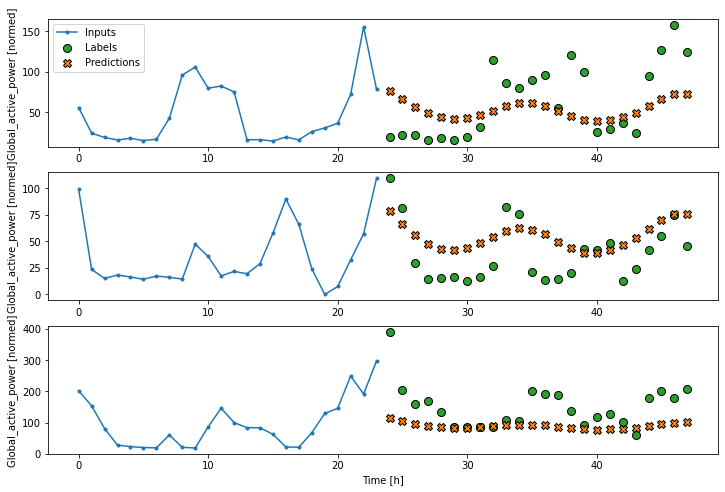

In [57]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Es peligroso añadir demasiadas unidades lstm, ya que pueden causar overfitting
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    # Shape [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

## Modelo auto-regresivo
En lugar de predecir todos los futuros pasos con una única predicción, los modelos auto-regresivos descomponen una predicción en múltiples pasos. De esta forma, la salida de cada modelo puede ser usada como entrada para realizar futuras predicciones, que estarán condicionadas por esta nueva entrada.

La principal ventaja de este tipo de modelos reside en que pueden utilizarse para producir outputs de longitud variable, algo que no ocurría en CNN ni RNN.

Construiremos una RNN auto-regresiva, este patrón podría ser aplicado a cualquier modelo que haya sido diseñado para devolver un solo time-step. Utilizaremos LSTMCell en lugar de LSTM, ya que estamos trabajando en un nivel menor.

In [58]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [59]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

Comenzamos definiendo un método warmup para inicializar su estado interno en base a sus inputs. Una vez entrenado, este estado capturará las partes relevantes del input de entradas. **Esto es equivalente al LSTM de un solo paso implementado antes.**

In [60]:
def warmup(self, inputs):
    # Forma del input => (batch, time, features)
    # Forma de x => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)
    
    # Forma de la predicción => (batch, features)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

Este método devuelve una predicción de un único time-step y el estado interno de la LSTM

In [61]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 1])

Utilizando el estado de la RNN y una predicción inicial es posible continuar iterando el modelo, alimentando las predicciones en cada paso como inputs.

In [62]:
def call(self, inputs, training=None):
    # Usar un TensorArray para capturar unrolled outputs automáticamente
    predictions = []
    # Inicializar el estado de LSTM
    prediction, state = self.warmup(inputs)
    
    # Insertar la primera predicción
    predictions.append(prediction)
    
    # Ejecutar el resto de pasos de la predicción
    for n in range(1, self.out_steps):
        # Usar la última predicción como input
        x = prediction
        # Ejecutar un paso de lstm
        x, state = self.lstm_cell(x, states=state, training=training)
        # Convertir la salida de lstm en una predicción
        prediction = self.dense(x)
        # Añadir la predicción al output
        predictions.append(prediction)
    
    # Forma de predictions => (time, batch, features)
    predictions = tf.stack(predictions)
    # Forma de predictions => (batch, time, features)
    predictions = tf.transpose(predictions, [1,0,2])
    
    return predictions

FeedBack.call = call

Ejecutamos este modelo con los inputs de ejemplo:

In [63]:
print('Forma del output: ', feedback_model(multi_window.example[0]).shape)

Forma del output:  (32, 24, 1)


Entrenamos el modelo

Epoch 1/20
756/756 [==============================] - 13s 13ms/step - loss: 5277.7173 - mean_absolute_error: 49.2708 - val_loss: 4196.3818 - val_mean_absolute_error: 46.2065
Epoch 2/20
756/756 [==============================] - 9s 12ms/step - loss: 3741.2520 - mean_absolute_error: 42.6943 - val_loss: 3122.2292 - val_mean_absolute_error: 42.2938
Epoch 3/20
756/756 [==============================] - 10s 13ms/step - loss: 3148.5371 - mean_absolute_error: 41.6052 - val_loss: 2713.4319 - val_mean_absolute_error: 41.1955
Epoch 4/20
756/756 [==============================] - 10s 13ms/step - loss: 2938.6028 - mean_absolute_error: 41.5151 - val_loss: 2586.5229 - val_mean_absolute_error: 41.2528
Epoch 5/20
756/756 [==============================] - 10s 13ms/step - loss: 2858.9304 - mean_absolute_error: 41.3443 - val_loss: 2549.6633 - val_mean_absolute_error: 41.0212
Epoch 6/20
756/756 [==============================] - 10s 14ms/step - loss: 2815.9546 - mean_absolute_error: 41.1578 - val_loss: 25

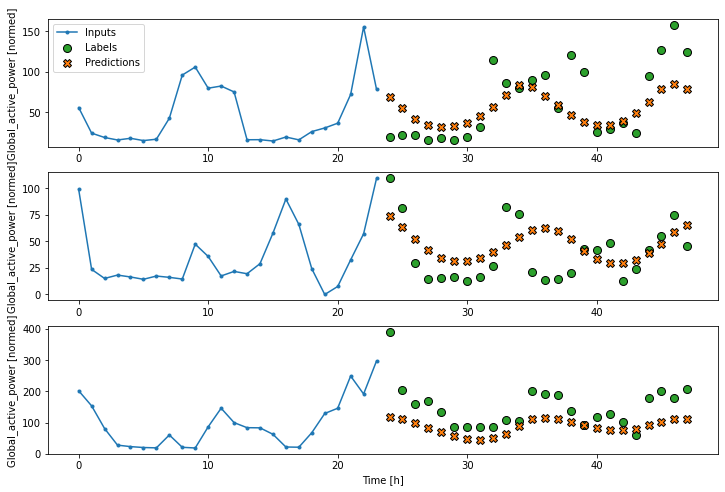

In [64]:
history = compile_and_fit(feedback_model, multi_window)

# IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

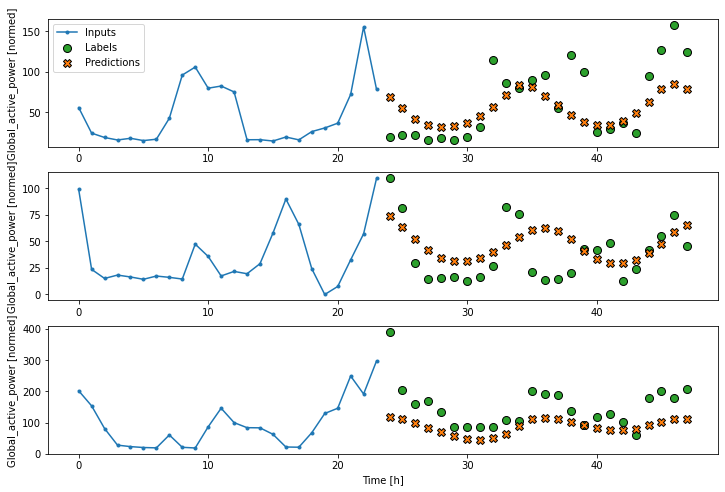

In [102]:
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

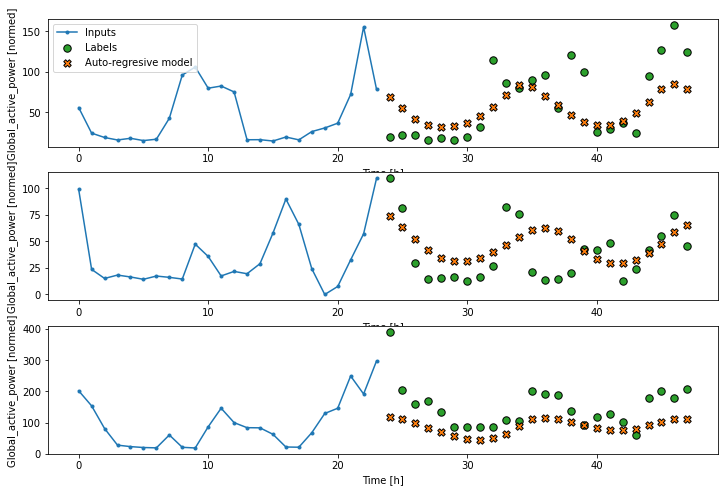

In [100]:
s_value = 55
plot_col = 'Global_active_power'

inputs, labels = multi_window.example
plt.figure(figsize=(12, 8))
plot_col_index = multi_window.column_indices[plot_col]
max_n = min(3, len(inputs))
for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(multi_window.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if multi_window.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(multi_window.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=s_value)
    
#     predictions = last_baseline(inputs)
#     plt.scatter(multi_window.label_indices, predictions[n, :, label_col_index],
#                   marker='X', edgecolors='k', label='Last Baseline',
#                   c='#7C7776', s=s_value)
    
    
#     predictions = repeat_baseline(inputs)
#     plt.scatter(multi_window.label_indices, predictions[n, :, label_col_index],
#                   marker='X', edgecolors='k', label='Repeat Baseline',
#                   c='#ff7f0e', s=s_value)
    
#     predictions = multi_linear_model(inputs)
#     plt.scatter(multi_window.label_indices, predictions[n, :, label_col_index],
#                   marker='X', edgecolors='k', label='Linear model',
#                   c='#ff7f0e', s=s_value)
    
#     predictions = multi_conv_model(inputs)
#     plt.scatter(multi_window.label_indices, predictions[n, :, label_col_index],
#                   marker='X', edgecolors='k', label='Convolutional model',
#                   c='#ff7f0e', s=s_value)

#     predictions = multi_lstm_model(inputs)
#     plt.scatter(multi_window.label_indices, predictions[n, :, label_col_index],
#                   marker='X', edgecolors='k', label='Recurrent model',
#                   c='#ff7f0e', s=s_value)
    
    predictions = feedback_model(inputs)
    plt.scatter(multi_window.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Auto-regresive model',
                  c='#ff7f0e', s=s_value)
    




    if n == 0:
      plt.legend()

    plt.xlabel('Time [h]')

plt.show()